In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [63]:
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from data_reader import *
from measures import *

In [3]:
pd.set_option('display.max_columns', None)

# fix lock.acquire() stalling of tqdm_notebook
from tqdm import tqdm as tqdm_orig
tqdm_orig.get_lock().locks = []

## Load data

In [18]:
df_gwas = load_gwas()
ppi_graph, df_ppi = load_biogrid()

df_snps = load_snp_data()

In [23]:
# get SNP gene ENTRZ id map
sub = df_gwas[['SNP_ID_CURRENT','SNP_GENE_IDS']].copy()
sub['SNP_ID_CURRENT'] = 'rs' + sub['SNP_ID_CURRENT']
sub['GENE_ENTREZ'] = sub['SNP_GENE_IDS'].str.split(',').str[0]

snp_gene_map = sub.set_index('SNP_ID_CURRENT').dropna().to_dict()['GENE_ENTREZ']

entrez = df_snps['SNP_name'].map(snp_gene_map)
df_snps['Gene_entrez'] = pd.to_numeric(entrez, errors='coerce')

## Check SNP data

In [61]:
df_snps.head()

,EFO_term,disease_name,SNP_name,chromosome,position,is_cancer,is_tad,Gene_entrez
0,EFO_0000095,Chronic lymphocytic leukemia,rs11083846,chr19,47207654,True,True,25865.0
1,EFO_0000095,Chronic lymphocytic leukemia,rs10936599,chr3,169492101,True,True,55892.0
2,EFO_0000095,Chronic lymphocytic leukemia,rs31490,chr5,1344458,True,True,81037.0
3,EFO_0000095,Chronic lymphocytic leukemia,rs11636802,chr15,56775597,True,True,105370831.0
4,EFO_0000095,Chronic lymphocytic leukemia,rs2236256,chr6,154478440,True,True,26034.0


## Check network coherence

In [8]:
graph = nx.Graph()
graph.add_edges_from([(1,2),(2,3),(3,4)])

In [9]:
for ns in [(1,2),(1,3), (1,2,4)]:
    print(ns, get_fraction_of_nonisolated_nodes(ns, graph), compute_network_coherence(graph, ns))

(1, 2) 1.0 1.0304638131
(1, 3) 0.0 -1.01005050379
(1, 2, 4) 0.6666666666666666 -0.964625279838


## Compute per-disease network coherences

In [29]:
ppi_genes = set(ppi_graph.nodes())
snp_genes = set(df_snps['Gene_entrez'].unique())
snps = set(df_snps['SNP_name'].unique())

print('PPI genes:', len(ppi_genes))
print('SNP genes:', len(snp_genes))
print('SNPs:', len(snps))
print('PPI/SNP gene overlap:', len(ppi_genes & snp_genes))

PPI genes: 21065
SNP genes: 1498
SNPs: 3226
PPI/SNP gene overlap: 1038


In [46]:
def compute_nc(sub_df):
    nc_data = []

    # must be (non)cancer/(non)tad only
    assert len(sub_df.is_cancer.unique()) == 1
    is_cancer = sub_df.is_cancer.iloc[0]
    assert len(sub_df.is_tad.unique()) == 1
    is_tad = sub_df.is_tad.iloc[0]
    
    # compute network coherences
    ppi_nodes = ppi_graph.nodes()
    for term, group in tqdm(sub_df.groupby('EFO_term')):
        genes = set(group['Gene_entrez'].unique())
        genes_in_ppi = genes & ppi_nodes

        if len(genes_in_ppi) > 0:
            nc = compute_network_coherence(ppi_graph, genes_in_ppi)
        else:
            nc = np.nan

        nc_data.append((term, nc, len(genes_in_ppi), len(genes)))

    df_nc = pd.DataFrame(nc_data, columns=['EFO_term', 'network_coherence', 'ppi_gene_num', 'total_gene_num'])
    df_nc['is_cancer'] = is_cancer
    df_nc['is_tad'] = is_tad
    return df_nc

In [59]:
df_nc_cancer_tad = compute_nc(df_snps[df_snps.is_cancer & df_snps.is_tad])
df_nc_cancer_notad = compute_nc(df_snps[df_snps.is_cancer & ~df_snps.is_tad])
df_nc_nocancer_tad = compute_nc(df_snps[~df_snps.is_cancer & df_snps.is_tad])
df_nc_nocancer_notad = compute_nc(df_snps[~df_snps.is_cancer & ~df_snps.is_tad])

df_nc = pd.concat([df_nc_cancer_tad, df_nc_cancer_notad, df_nc_nocancer_tad, df_nc_nocancer_notad], axis=0)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

Uniform random results, retrying with more iterations (1000 -> 3000)


HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Uniform random results, retrying with more iterations (1000 -> 3000)


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

In [60]:
df_nc.head()

,EFO_term,network_coherence,ppi_gene_num,total_gene_num,is_cancer,is_tad
0,EFO_0000095,-0.119159,5,7,True,True
1,EFO_0000178,NaN,1,2,True,True
2,EFO_0000182,NaN,0,1,True,True
3,EFO_0000305,-0.105463,5,8,True,True
4,EFO_0000571,NaN,1,1,True,True


## Plot result

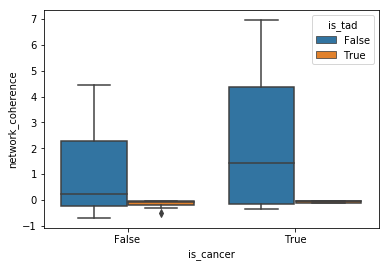

In [67]:
sns.boxplot(x='is_cancer', y='network_coherence', data=df_nc, hue='is_tad');